# Tuning LoRA Hyperparameters - Experiments Vertical, Horizontal and r

## Environment Setup

In [4]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%%capture
import sys
sys.path.append('src')

import boto3

import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import HyperparameterTuner

import warnings
warnings.filterwarnings('ignore')

from src.util import (
    count_parameters, 
    calc_combinations
)
from src.nb_helper import (
    display_tuning_jobs,
    get_default_estimator_parameters,
    p,
    capture_results,
    graph_results,
    roberta_total, 
    roberta_learnable
)
from amtviz import visualize_tuning_job
import altair as alt
sm = boto3.client('sagemaker')

## Experiments

Let's try some experiments. For all of the experiments we use one learning rate (and weight decay / dropout) as a basis. We use the learning rate we found with the tuning job.

In [3]:
# We continue to use the results of the base lora tuner
%store -r
assert base_lora_tuner_name
base_lora_tuner = HyperparameterTuner.attach(base_lora_tuner_name)
base_lora_tuner_name

'lora-base-tuning-231031-1649'

In [4]:
base_lora_tuner.wait()
desc = sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=base_lora_tuner.describe()['HyperParameterTuningJobName'])
print(desc['HyperParameterTuningJobName'], '=>', desc['HyperParameterTuningJobStatus'])
best_hyperparameters = desc['BestTrainingJob']['TunedHyperParameters']
print('Best parameters found:', best_hyperparameters)
best_hyperparameters = {k:float(v.replace('"', '')) for k, v in best_hyperparameters.items()}; best_hyperparameters

!
lora-base-tuning-231031-1649 => Completed
Best parameters found: {'sst2-learning-rate': '0.0021137792486097275'}


{'sst2-learning-rate': 0.0021137792486097275}

### Vertical / Layers

According to our intuition shouldn't we see that modules closer to the task head have bigger impact on the performance after finetuning?

With finetuning we are adapting the modules in our neural network. The task we want to finetune on is usually something different than we pre-trained on, e.g. we finetune on `sentiment analysis` of emails, while we pre-trained on `next token` prediction.

In this scenario we would expect that the impact of changes close to the bottom of the network, where the inputs come in, are smaller than the changes a the top of the network. As the understanding of language (bottom) would not be as strongly impacted as what to do with it (top).

So let's put this to the test and only tune some layers from the bottom, from the top, and evenly spread out.



In [5]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, TuningJobCompletionCriteriaConfig
vertical_estimator = PyTorch(**get_default_estimator_parameters())
vertical_estimator.set_hyperparameters(**{'sst2-lora-r': 8, **best_hyperparameters})

n_trials = 7
hpt_ranges = {
    'dummy': CategoricalParameter(list(range(0, n_trials))),
    'sst2-lora-config': CategoricalParameter(['12_upper', '12_lower', '12_even', 'all'])
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Grid',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = vertical_estimator,
    base_tuning_job_name = 'lora-vertical',
    max_jobs = calc_combinations(hpt_ranges), 
    max_parallel_jobs = 10, 
))}


lora_vertical_tuner = HyperparameterTuner(**tuner_parameters)
lora_vertical_tuner.fit(wait=False)

Using provided s3_resource


### Horizontal / Modules

We just submitted some tuning jobs to gauge the vertical (by layer) impact, but what about the horizontal approach to explore the impact of the individual modules, e.g. the query vectors?

There are a lot of interactions between these modules. Hence it would be good to also experiment with the impact of combining these modules. But given the combinatorial explosion of possible trials we stick to validating each module individually, for now. Another important (over-)simplification is to keep in mind is the `r` parameter. The number of parameters of a query vector is very different from the up-projection of the feed-forward layer. But to get a first impression we keep `r` fixed. These are the modules we look into:

Attention:
- q - query
- k - key
- v - value
- o - output

Feed Forward:
- u - up projection, i.e. 768 -> 3072
- d - down projection, i.e. 3072 -> 768


In [6]:
horizontal_estimator = PyTorch(**get_default_estimator_parameters())
horizontal_estimator.set_hyperparameters(**{'sst2-lora-r': 8, **best_hyperparameters})

hpt_ranges = {
    'dummy': CategoricalParameter(list(range(0, n_trials))),
    'sst2-lora-config': CategoricalParameter(['att_q', 'att_k', 'att_v', 'att_o', 'ff_u', 'ff_d'])
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Grid',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = horizontal_estimator,
    base_tuning_job_name = 'lora-horizontal',
    max_jobs = calc_combinations(hpt_ranges), 
    max_parallel_jobs = 7, 
))}

lora_horizontal_tuner = HyperparameterTuner(**tuner_parameters)
lora_horizontal_tuner.fit(wait=False)

Using provided s3_resource


### Rank

The third angle we explore is chosing `r`. When increasing `r` slowly, at some point we must cross the threshold where `r` becomes higher than the rank of `lora_A` and `lora_B`. Increasing `r` above that level will only make the training more costly with no additional benefit for our model's performance. What is that threshold?

_Sidebar: As we use the Random Search strategy with SageMaker AMT and accordingly no learning is happening in between the trials, theoretically, we could run all trials of this tuning in parallel. Also, we could run this tuning job in parallel to the two tuning jobs before (vertical and horizontal exploration), but we would need to increase our account limit for the training instance types to more than 20, which we haven't. 
So instead, we wait for the other tuning jobs to finish:_

In [7]:
lora_vertical_tuner.wait()

....................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [8]:
lora_r_estimator = PyTorch(**get_default_estimator_parameters())
lora_r_estimator.set_hyperparameters(**{'sst2-lora-r': 8, 'sst2-lora-config': 'all', **best_hyperparameters})

n_trials = 8
hpt_ranges = {
    'sst2-lora-r': CategoricalParameter([1, 2, 4, 8, 16, 32]),
    'dummy': CategoricalParameter(list(range(0, n_trials))),
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Grid',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = lora_r_estimator,
    base_tuning_job_name = 'lora-r',
    max_jobs = calc_combinations(hpt_ranges), 
    max_parallel_jobs = 10, 
))}

lora_r_tuner = HyperparameterTuner(**tuner_parameters)
lora_r_tuner.fit(wait=False)

Using provided s3_resource


### Analysis

#### Vertical

'lora-vertical-231031-2138'

Tuning job lora-vertical-231031-2138 status: Completed

Number of training jobs with valid objective: 28
Lowest: 0.9243119359016418 Highest 0.9461008906364441


dummy sst2-lora-config                         TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds              TuningJobName  sst2_valid_acc
6       0              all  lora-vertical-231031-2138-022-efd2ceca         Completed 2023-10-31 21:59:41+01:00 2023-10-31 22:12:40+01:00                       779.0  lora-vertical-231031-2138        0.946101
4       2              all  lora-vertical-231031-2138-024-a5106dc6         Completed 2023-10-31 21:59:45+01:00 2023-10-31 22:12:50+01:00                       785.0  lora-vertical-231031-2138        0.944954
2       4              all  lora-vertical-231031-2138-026-407fcbff         Completed 2023-10-31 22:00:54+01:00 2023-10-31 22:11:33+01:00                       639.0  lora-vertical-231031-2138        0.943807
13      0          12_even  lora-vertical-231031-2138-015-29c47c00         Completed 2023-10-31 21:49:22+01:00 2023-10-31 21:58:26+01:00                       544.0  lora-vertical-231031-2138        0.942661
24      3         12_upper  lora-vertical-231031-2138-004-4e00a91b         Completed 2023-10-31 21:40:06+01:00 2023-10-31 21:49:19+01:00                       553.0  lora-vertical-231031-2138        0.941514
8       5          12_even  lora-vertical-231031-2138-020-5a696a44         Completed 2023-10-31 21:50:35+01:00 2023-10-31 22:01:14+01:00                       639.0  lora-vertical-231031-2138        0.941514
1       5              all  lora-vertical-231031-2138-027-3ccb28a7         Completed 2023-10-31 22:01:15+01:00 2023-10-31 22:12:03+01:00                       648.0  lora-vertical-231031-2138        0.940367
14      6         12_lower  lora-vertical-231031-2138-014-57561b5f         Completed 2023-10-31 21:49:39+01:00 2023-10-31 21:58:52+01:00                       553.0  lora-vertical-231031-2138        0.939220
11      2          12_even  lora-vertical-231031-2138-017-29426fa4         Completed 2023-10-31 21:49:28+01:00 2023-10-31 22:00:47+01:00                       679.0  lora-vertical-231031-2138        0.939220
10      3          12_even  lora-vertical-231031-2138-018-f85bcccf         Completed 2023-10-31 21:49:24+01:00 2023-10-31 22:00:38+01:00                       674.0  lora-vertical-231031-2138        0.938073

Cache Hit/Miss: HHHHHHHHHHHHHHHHHHHHHHHHHHHH


WARN shape dropped as it is incompatible with "bar".
WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "zero" is dropped as it does not work with point scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


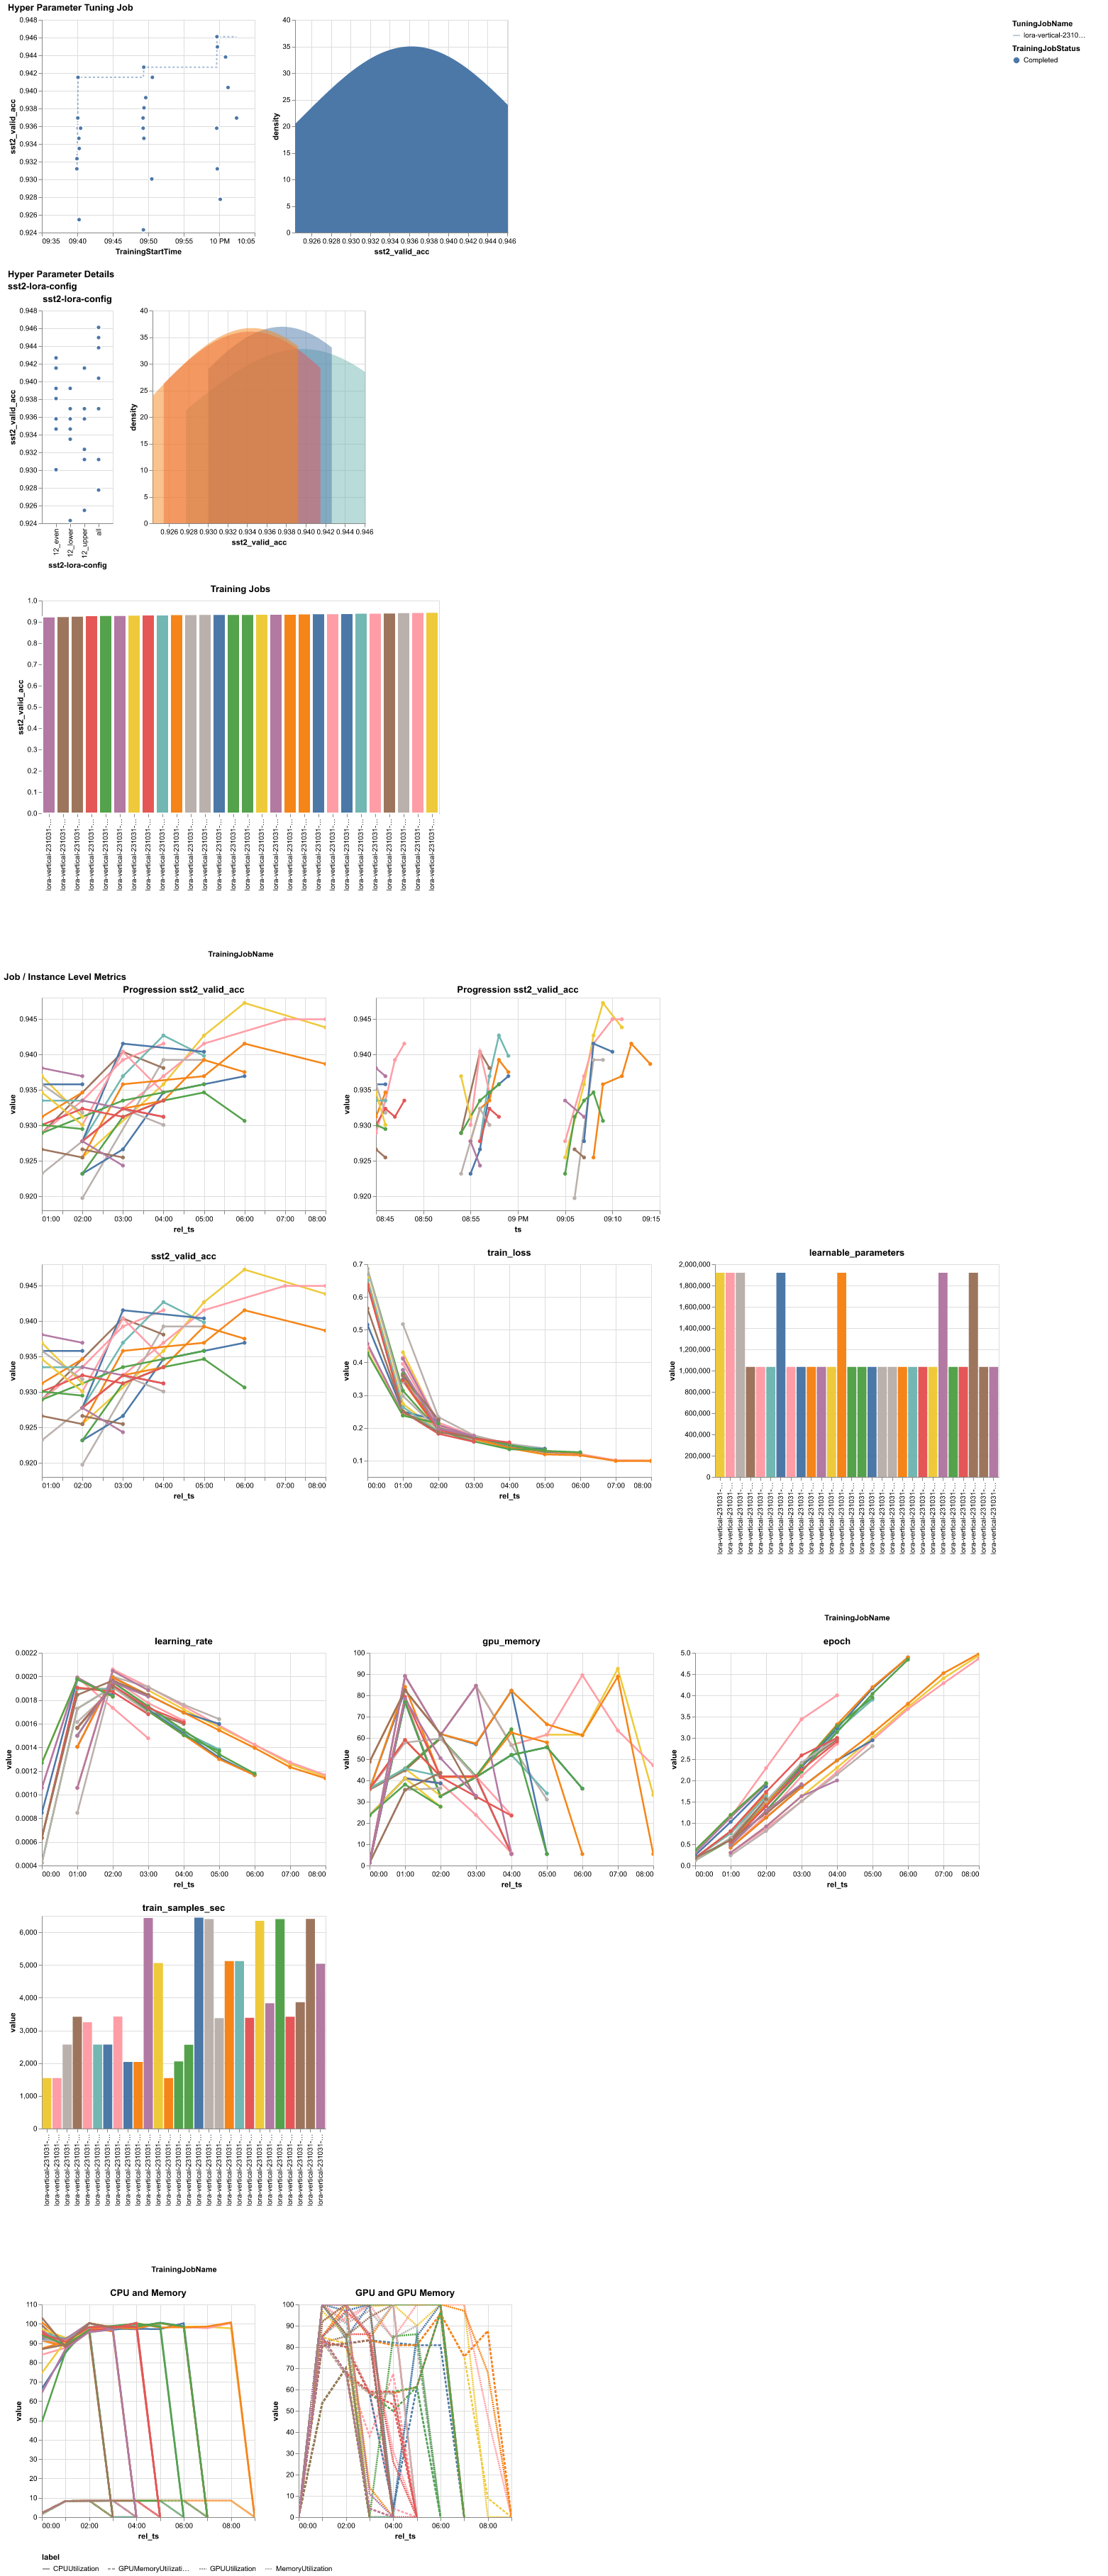

In [6]:
display_tuning_jobs(lora_vertical_tuner)

The vertical exploration was insightful, but not at all what I expected. 

We have a 12 layers model and compared these four configurations:

- __all__: We finetuned all 12 layers using LoRA. This is just for comparison and has double the amount of parameters than the other combinations.
- __lower__: We only finetuned adapters for the 6 lowest layers, closest to the inputs.
- __upper__: We only finetuned adapters for the 6 top layers, closest to the task.
- __even__: We only finetuned adapters for 6 layers, evenly spread out over. 

For our task `sentiment analysis` it appeared reasonable to me that a lot of the interpretation of the inputs could be close to the task head, and is not so much dependent on individual words being meaningful on their own. If that were the case then __upper__ should have outperformed __lower__. __Even__ was the best scenario. But even this scenario was not able to outperform __all__ with double the amount of parameters. 

If you feel inclined, and you ran this notebook for yourself, interact with it. You can select the scenario that is interesting to you and see how the results change. One notable find is that when selecting __upper__ the GPU memory utilization (`gpu_memory`) goes down from 80+% to 55%. Likely because the gradients then only have to be calculated for a relatively short path, just for the classifier and the upper layers. 

Also checkout how the training velocity (`train_samples_sec`).

'lora-horizontal-231031-2138'

Tuning job lora-horizontal-231031-2138 status: Completed

Number of training jobs with valid objective: 42
Lowest: 0.9151375889778137 Highest 0.9449541568756104


dummy sst2-lora-config                           TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds                TuningJobName  sst2_valid_acc
7       6             ff_u  lora-horizontal-231031-2138-035-d05e18b7         Completed 2023-10-31 22:24:24+01:00 2023-10-31 22:36:26+01:00                       722.0  lora-horizontal-231031-2138        0.944954
1       5             ff_d  lora-horizontal-231031-2138-041-66fb0d02         Completed 2023-10-31 22:33:50+01:00 2023-10-31 22:44:44+01:00                       654.0  lora-horizontal-231031-2138        0.941514
6       0             ff_d  lora-horizontal-231031-2138-036-09aac147         Completed 2023-10-31 22:27:07+01:00 2023-10-31 22:36:05+01:00                       538.0  lora-horizontal-231031-2138        0.940367
0       6             ff_d  lora-horizontal-231031-2138-042-9f3baec9         Completed 2023-10-31 22:37:52+01:00 2023-10-31 22:48:46+01:00                       654.0  lora-horizontal-231031-2138        0.939220
8       5             ff_u  lora-horizontal-231031-2138-034-ea2572d6         Completed 2023-10-31 22:24:10+01:00 2023-10-31 22:32:12+01:00                       482.0  lora-horizontal-231031-2138        0.938073
21      6            att_v  lora-horizontal-231031-2138-021-99b457a5         Completed 2023-10-31 22:02:13+01:00 2023-10-31 22:12:58+01:00                       645.0  lora-horizontal-231031-2138        0.938073
5       1             ff_d  lora-horizontal-231031-2138-037-14f85a1b         Completed 2023-10-31 22:27:58+01:00 2023-10-31 22:37:12+01:00                       554.0  lora-horizontal-231031-2138        0.938073
3       3             ff_d  lora-horizontal-231031-2138-039-ae71cf43         Completed 2023-10-31 22:29:56+01:00 2023-10-31 22:38:49+01:00                       533.0  lora-horizontal-231031-2138        0.936927
26      1            att_v  lora-horizontal-231031-2138-016-3205f555         Completed 2023-10-31 21:58:30+01:00 2023-10-31 22:07:33+01:00                       543.0  lora-horizontal-231031-2138        0.936927
10      3             ff_u  lora-horizontal-231031-2138-032-4ef75c2a         Completed 2023-10-31 22:19:58+01:00 2023-10-31 22:27:46+01:00                       468.0  lora-horizontal-231031-2138        0.934633

Cache Hit/Miss: HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH


WARN shape dropped as it is incompatible with "bar".
WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "zero" is dropped as it does not work with point scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


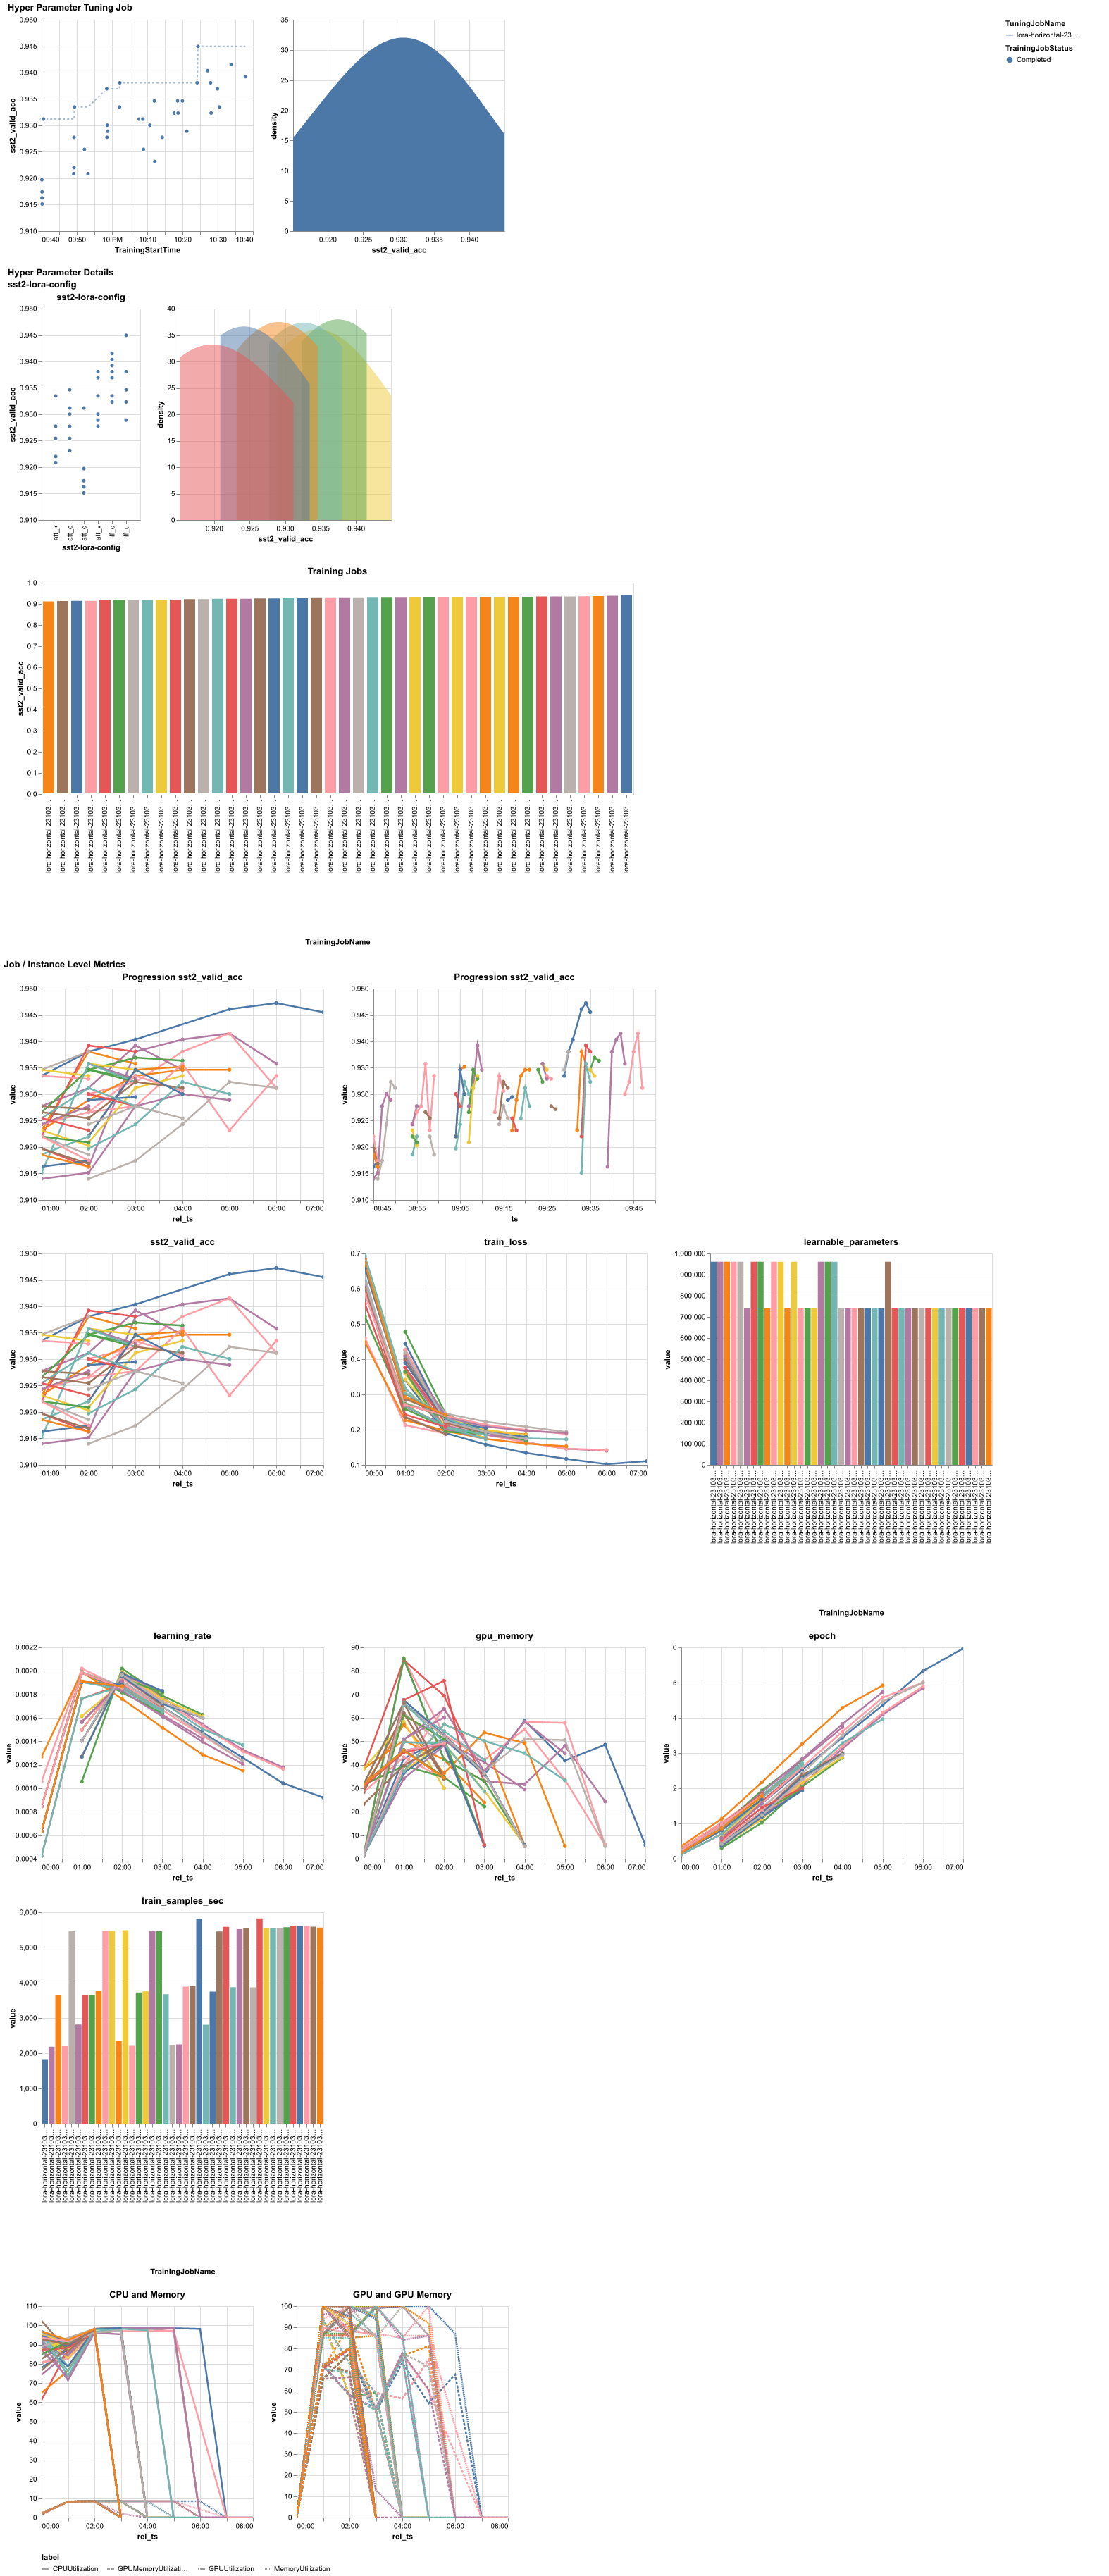

In [7]:
display_tuning_jobs(lora_horizontal_tuner)

#### Horizontal

The __horizontal__ was great. FIXME

Reviewing different values of `r` was different to what we hoped for. We saw with a larger `r` that we also got more variance. This was likely a sign of overfitting then. FIXME. This is also supported by the high variance on the `valid_loss` as you can see above. 

Also, we saw that bla bla, so let's try horizonatal combinations bla bla

'lora-r-231031-2216'

Tuning job lora-r-231031-2216        status: Completed

Number of training jobs with valid objective: 48
Lowest: 0.9174311757087708 Highest 0.9472476840019226


dummy  sst2-lora-r                  TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds       TuningJobName  sst2_valid_acc
17      5            1  lora-r-231031-2216-031-e703d7fc         Completed 2023-10-31 22:52:23+01:00 2023-10-31 23:05:37+01:00                       794.0  lora-r-231031-2216        0.947248
9       6            4  lora-r-231031-2216-039-24ff43c2         Completed 2023-10-31 22:56:08+01:00 2023-10-31 23:07:42+01:00                       694.0  lora-r-231031-2216        0.943807
20      4            8  lora-r-231031-2216-028-f5019725         Completed 2023-10-31 22:42:45+01:00 2023-10-31 22:53:19+01:00                       634.0  lora-r-231031-2216        0.943807
22      4            2  lora-r-231031-2216-026-1e3899a1         Completed 2023-10-31 22:41:58+01:00 2023-10-31 22:52:36+01:00                       638.0  lora-r-231031-2216        0.942661
4       7            2  lora-r-231031-2216-044-b0b3dd8a         Completed 2023-10-31 23:06:23+01:00 2023-10-31 23:17:57+01:00                       694.0  lora-r-231031-2216        0.942661
46      0            2  lora-r-231031-2216-002-a639683a         Completed 2023-10-31 22:17:33+01:00 2023-10-31 22:30:33+01:00                       780.0  lora-r-231031-2216        0.942661
31      2           16  lora-r-231031-2216-017-39e72a8f         Completed 2023-10-31 22:29:58+01:00 2023-10-31 22:40:42+01:00                       644.0  lora-r-231031-2216        0.942661
44      0            8  lora-r-231031-2216-004-c69d3c49         Completed 2023-10-31 22:17:29+01:00 2023-10-31 22:28:08+01:00                       639.0  lora-r-231031-2216        0.941514
13      5           16  lora-r-231031-2216-035-3b55a4dd         Completed 2023-10-31 22:54:07+01:00 2023-10-31 23:04:51+01:00                       644.0  lora-r-231031-2216        0.941514
14      5            8  lora-r-231031-2216-034-8dadc534         Completed 2023-10-31 22:53:53+01:00 2023-10-31 23:06:57+01:00                       784.0  lora-r-231031-2216        0.941514

Cache Hit/Miss: HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH


WARN shape dropped as it is incompatible with "bar".


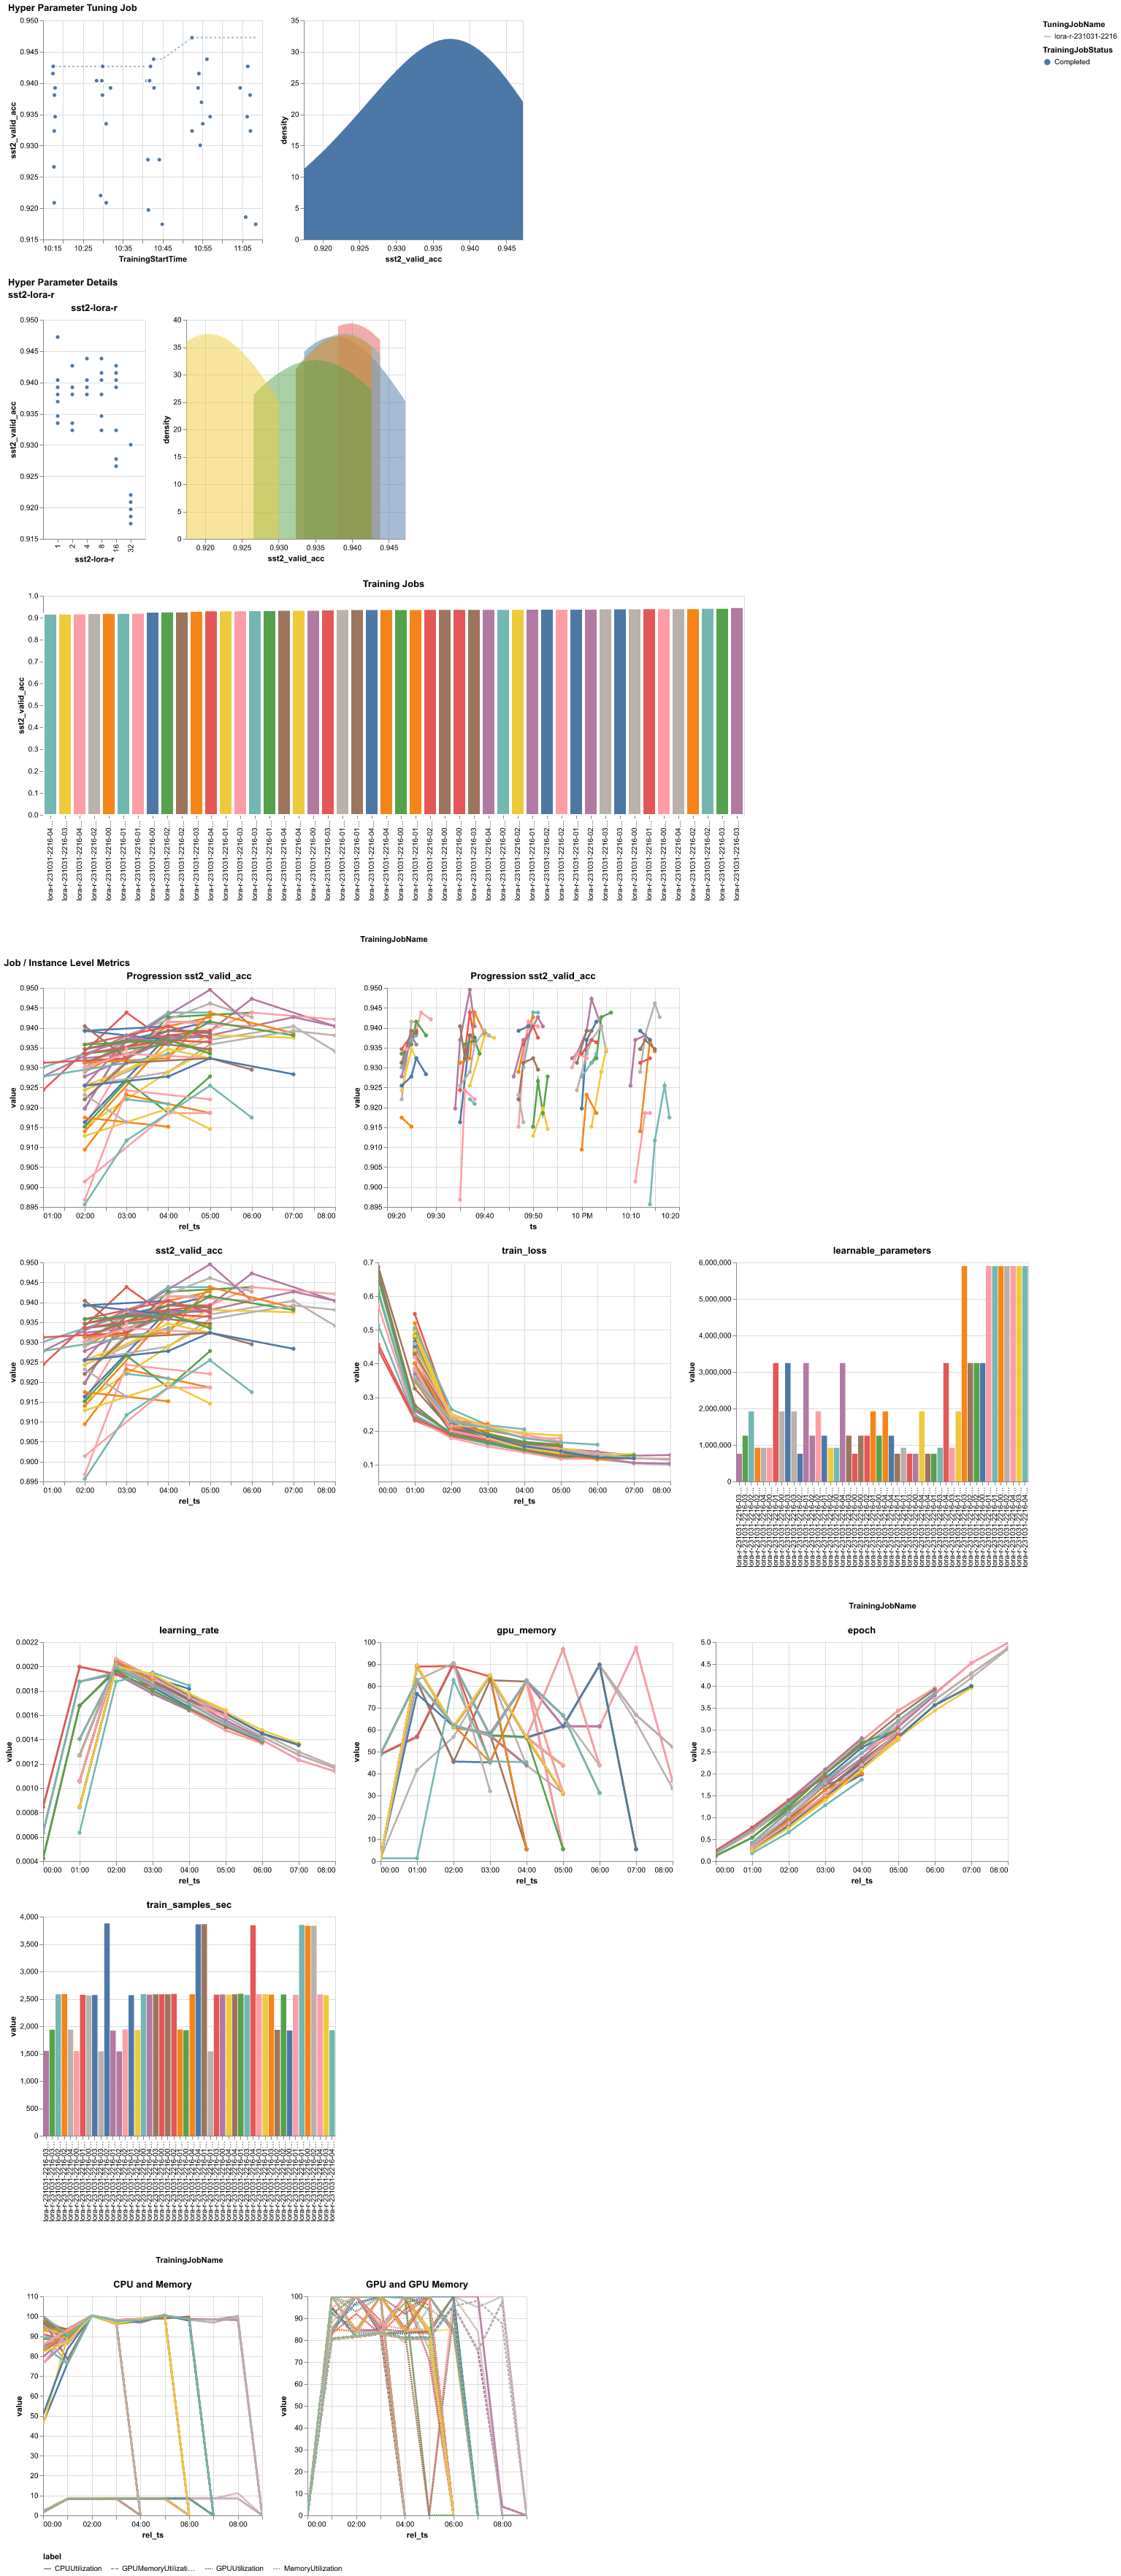

WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "zero" is dropped as it does not work with point scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


In [8]:
display_tuning_jobs(lora_r_tuner)

### Horizontal Combinations

In [12]:
horizontal_comb_estimator = PyTorch(**get_default_estimator_parameters())
horizontal_comb_estimator.set_hyperparameters(**{'sst2-lora-r': 8, **best_hyperparameters})

n_trials = 4
hpt_ranges = {
    'dummy': CategoricalParameter(list(range(0, n_trials))),
    'sst2-lora-config': CategoricalParameter(['att_q+ff_u','ff_d+ff_u','att_k+ff_u','att_v+ff_u','att_o+ff_u', 'att_qk+ff_u','att_qv+ff_u']) 
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Grid',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = horizontal_comb_estimator,
    base_tuning_job_name = 'lora-horiz-comb',
    max_jobs = calc_combinations(hpt_ranges), 
    max_parallel_jobs = 10, 
))}

lora_horiz_comb_tuner = HyperparameterTuner(**tuner_parameters)
lora_horiz_comb_tuner.fit(wait=False)

Using provided s3_resource


'lora-horiz-comb-231031-2323'

Tuning job lora-horiz-comb-231031-2323 status: Completed

Number of training jobs with valid objective: 28
Lowest: 0.9254587292671204 Highest 0.9518348574638367


dummy sst2-lora-config                           TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds                TuningJobName  sst2_valid_acc
12      3       att_v+ff_u  lora-horiz-comb-231031-2323-016-acf5989d         Completed 2023-10-31 23:36:28+01:00 2023-10-31 23:47:52+01:00                       684.0  lora-horiz-comb-231031-2323        0.951835
3       0      att_qv+ff_u  lora-horiz-comb-231031-2323-025-fb2380c8         Completed 2023-10-31 23:46:35+01:00 2023-10-31 23:57:13+01:00                       638.0  lora-horiz-comb-231031-2323        0.950688
22      1        ff_d+ff_u  lora-horiz-comb-231031-2323-006-6a35bcdb         Completed 2023-10-31 23:24:44+01:00 2023-10-31 23:35:23+01:00                       639.0  lora-horiz-comb-231031-2323        0.947248
7       0      att_qk+ff_u  lora-horiz-comb-231031-2323-021-ebfb25b1         Completed 2023-10-31 23:44:42+01:00 2023-10-31 23:56:27+01:00                       705.0  lora-horiz-comb-231031-2323        0.946101
18      1       att_k+ff_u  lora-horiz-comb-231031-2323-010-5aa24b52         Completed 2023-10-31 23:24:29+01:00 2023-10-31 23:35:08+01:00                       639.0  lora-horiz-comb-231031-2323        0.943807
21      2        ff_d+ff_u  lora-horiz-comb-231031-2323-007-2b85e431         Completed 2023-10-31 23:24:21+01:00 2023-10-31 23:33:35+01:00                       554.0  lora-horiz-comb-231031-2323        0.943807
16      3       att_k+ff_u  lora-horiz-comb-231031-2323-012-60269f86         Completed 2023-10-31 23:35:06+01:00 2023-10-31 23:45:45+01:00                       639.0  lora-horiz-comb-231031-2323        0.942661
1       2      att_qv+ff_u  lora-horiz-comb-231031-2323-027-c4d7414f         Completed 2023-10-31 23:48:18+01:00 2023-10-31 23:56:27+01:00                       489.0  lora-horiz-comb-231031-2323        0.942661
20      3        ff_d+ff_u  lora-horiz-comb-231031-2323-008-f183ab0d         Completed 2023-10-31 23:24:49+01:00 2023-10-31 23:34:07+01:00                       558.0  lora-horiz-comb-231031-2323        0.941514
27      0       att_q+ff_u  lora-horiz-comb-231031-2323-001-48101c93         Completed 2023-10-31 23:24:16+01:00 2023-10-31 23:36:51+01:00                       755.0  lora-horiz-comb-231031-2323        0.941514

Cache Hit/Miss: HHHHHHHHHHHHHHHHHHHHHHHHHHHH


WARN shape dropped as it is incompatible with "bar".
WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "zero" is dropped as it does not work with point scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


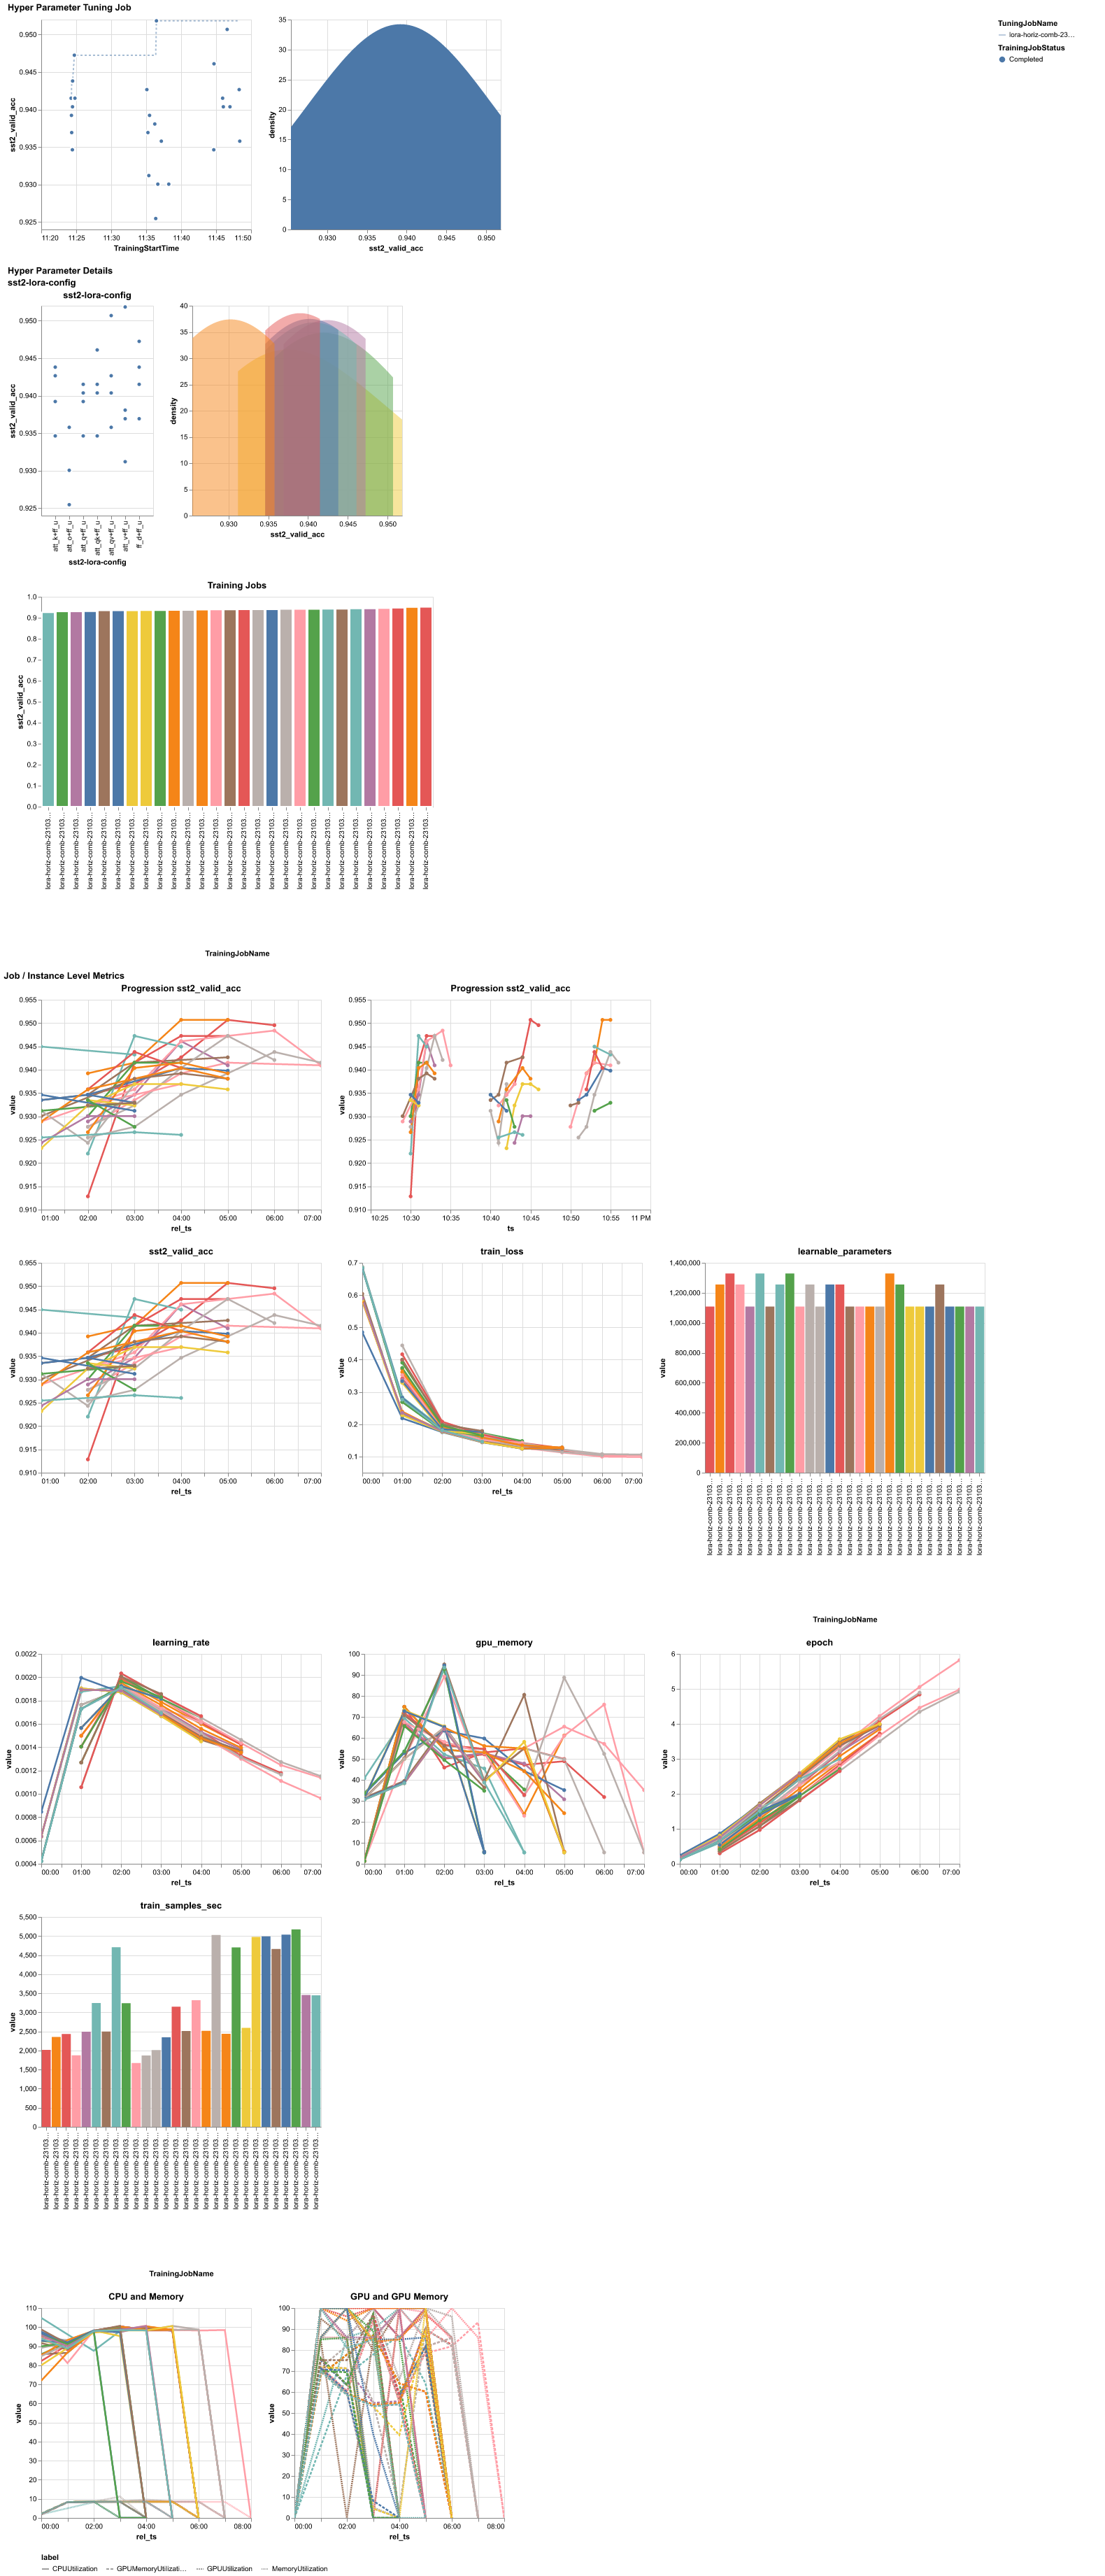

In [9]:
display_tuning_jobs(lora_horiz_comb_tuner)